In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import pickle as pkl
import pandas as pd
import os
import requests as r
from sklearn.metrics import accuracy_score
import random

np.random.seed(37)

random.seed(1254)

tf.random.set_seed(89)

tf.executing_eagerly()


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

stages = ['CE', 'SCL']

dataset = 'AFAD-Full'
net = 'R50'
version = 'V1'

stage = stages[0]

script_name_template = '{}-{}-{}-BatchNorm-MultiOutput-AutoAug-224-{}'
script_name = script_name_template.format(version, dataset, net, stage)

In [2]:
if net == 'R50':
    from tensorflow.keras.applications.resnet_v2 import preprocess_input
    from tensorflow.keras.applications import ResNet50V2 as backbone_net
if net == 'Mnet':
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    from tensorflow.keras.applications import MobileNetV2 as backbone_net

In [3]:
def encode(data, mask):
    labels = []
    for item in data:
        labels.append(mask[item])
    return labels

In [4]:
csv_target_train = '{}/train.csv'.format(dataset)
directory_data = dataset
df_train = pd.read_csv(csv_target_train)

if dataset == 'FairFace':
    csv_target_val = '{}/val.csv'.format(dataset)
    df_val = pd.read_csv(csv_target_val)

if dataset == 'AFAD-Full':
    bins = [0, 3, 10, 20, 30, 40, 50, 60, 70, np.inf]
    names = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
    df_train['age'] = pd.cut(df_train['age_abs'], bins, labels=names)

if dataset == 'UTKFace':
    directory_data = './'
    
df_train

,file,gender,age_abs,age
0,23/112/190424-1.jpg,Female,23,20-29
1,27/111/139620-0.jpg,Male,27,20-29
2,36/111/306718-2.jpg,Male,36,30-39
3,38/111/579575-0.jpg,Male,38,30-39
4,20/111/195051-0.jpg,Male,20,10-19
...,...,...,...,...
165496,20/112/108659-0.jpg,Female,20,10-19
165497,36/111/482001-1.jpg,Male,36,30-39
165498,19/111/42720-0.jpg,Male,19,10-19
165499,24/111/161789-0.jpg,Male,24,20-29


In [5]:
def label2dict(df):
    values = df.unique()
    d = {}
    for idx, v in enumerate(values):
        d[v] = idx
    return d
def apply_encode(map_dict, col, row):
    return map_dict[row[col]]

In [6]:
target_col = ['gender', 'race', 'age']
if dataset == 'AFAD-Full':
    target_col = ['gender', 'age']
num_classes = []
for col in target_col:
    num_classes.append(df_train[col].nunique())
input_shape = (224, 224, 3)
batch_size = 64
learning_rate = 0.001
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.1
validation_split = 0.1

In [7]:
target_col_data = []
for col in target_col:
    col2 = col + '_sparse'
    target_col_data.append(col2)
    map_dict = label2dict(df_train[col])
    df_train[col2] = df_train.apply(lambda row: apply_encode(map_dict, col, row), axis=1)
    if dataset == 'FairFace':
        df_val[col2] = df_val.apply(lambda row: apply_encode(map_dict, col, row), axis=1)

In [8]:
x_col = 'file'
y_col = target_col_data
train_generator = keras.preprocessing.image.ImageDataGenerator(
    validation_split=validation_split
)
val_generator = keras.preprocessing.image.ImageDataGenerator(
)


if dataset == 'FairFace':
    train_iter = train_generator.flow_from_dataframe(
        df_train,
        directory=directory_data,
        x_col=x_col,
        y_col=y_col,
        class_mode="multi_output",
        target_size=(input_shape[0], input_shape[1]),
        batch_size=batch_size,
    )

    val_iter = val_generator.flow_from_dataframe(
        df_val,
        directory=directory_data,
        x_col=x_col,
        y_col=y_col,
        class_mode="multi_output",
        target_size=(input_shape[0], input_shape[1]),
        batch_size=batch_size,
        shuffle=False,
    )
else:
    train_iter = train_generator.flow_from_dataframe(
        df_train,
        directory=directory_data,
        x_col=x_col,
        y_col=y_col,
        class_mode="multi_output",
        target_size=(input_shape[0], input_shape[1]),
        batch_size=batch_size,
        subset='training'
    )

    val_iter = train_generator.flow_from_dataframe(
        df_train,
        directory=directory_data,
        x_col=x_col,
        y_col=y_col,
        class_mode="multi_output",
        target_size=(input_shape[0], input_shape[1]),
        batch_size=batch_size,
        subset='validation'
    )

Found 148951 validated image filenames.
Found 16550 validated image filenames.


In [9]:
callbacks = []
if len(target_col) == 1:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)
else:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_{}_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.02),
        layers.experimental.preprocessing.RandomWidth(0.2),
        layers.experimental.preprocessing.RandomHeight(0.2),
        layers.experimental.preprocessing.RandomTranslation((-0.2, 0.2), (-0.2, 0.2)),
        layers.experimental.preprocessing.RandomContrast((0.1, 0.2))
        
    ]
)
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    x = layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)(augmented)
    outputs = resnet(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="encoder")
    return model

In [11]:
def create_classifier(encoder, trainable=True, training=True):
    
    encoder.trainable = trainable

    inputs = keras.Input(shape=input_shape, name="input")
    features = encoder(inputs, training=training)
    outputs = []
    for idx, num_class in enumerate(num_classes):
        _features = layers.Dropout(dropout_rate, name="dropout_" + target_col[idx])(features)
        _features = layers.Dense(hidden_units, activation="relu", name = "features_"+ target_col[idx])(_features)
        _features = layers.Dropout(dropout_rate, name="dropout2_" + target_col[idx])(_features)
        outputs.append(layers.Dense(num_class, activation="softmax", name=target_col[idx])(_features))

    model = keras.Model(inputs=inputs, outputs=outputs, name="classifier")
    metrics = {}
    loss = []
    loss_weights = []
    for col in target_col:
        metrics[col] = keras.metrics.SparseCategoricalAccuracy()
        loss.append(keras.losses.SparseCategoricalCrossentropy())
        loss_weights.append(0.1)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=loss,
        metrics=metrics,
        loss_weights=loss_weights
    )
    return model

In [12]:
encoder = create_encoder()
encoder.summary()
classifier = create_classifier(encoder)
classifier.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
rescaling (Rescaling)        (None, None, None, 3)     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________
Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)    

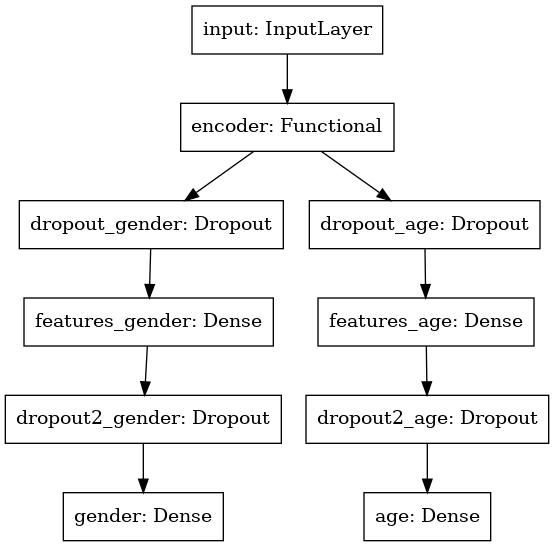

In [13]:
keras.utils.plot_model(classifier)

In [14]:
history = classifier.fit(train_iter, batch_size=batch_size, epochs=num_epochs, validation_data=val_iter, callbacks=callbacks)

classifier.save('./ckpt/{}-{}.h5'.format(script_name, 'last'))

Epoch 1/50
2328/2328 [==============================] - 687s 292ms/step - loss: 0.1423 - gender_loss: 0.3835 - age_loss: 1.0399 - gender_sparse_categorical_accuracy: 0.8272 - age_sparse_categorical_accuracy: 0.5394 - val_loss: 0.1251 - val_gender_loss: 0.2456 - val_age_loss: 1.0056 - val_gender_sparse_categorical_accuracy: 0.8961 - val_age_sparse_categorical_accuracy: 0.5407


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
2328/2328 [==============================] - 468s 201ms/step - loss: 0.1174 - gender_loss: 0.1973 - age_loss: 0.9768 - gender_sparse_categorical_accuracy: 0.9227 - age_sparse_categorical_accuracy: 0.5509 - val_loss: 0.1102 - val_gender_loss: 0.1706 - val_age_loss: 0.9315 - val_gender_sparse_categorical_accuracy: 0.9353 - val_age_sparse_categorical_accuracy: 0.5754
Epoch 3/50
2328/2328 [==============================] - 450s 193ms/step - loss: 0.1094 - gender_loss: 0.1619 - age_loss: 0.9318 - gender_sparse_categorical_accuracy: 0.9389 - age_sparse_categorical_accuracy: 0.5745 - val_loss: 0.1051 - val_gender_loss: 0.1451 - val_age_loss: 0.9059 - val_gender_sparse_categorical_accuracy: 0.9439 - val_age_sparse_categorical_accuracy: 0.5884
Epoch 4/50
2328/2328 [==============================] - 439s 189ms/step - loss: 0.1043 - gender_loss: 0.1394 - age_loss: 0.9039 - gender_sparse_categorical_accuracy: 0.9489 - age_sparse_categorical_accuracy: 0.5864 - val_loss: 0.0994 - val_gend

In [15]:
stage = stages[1]
script_name = script_name_template.format(version, dataset, net, stage)

In [16]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = []
    for col in target_col:
        outputs.append(layers.Dense(projection_units, activation="relu", name="features_" + col)(features))
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="encoder_with_projection-head"
    )
    return model

Model: "encoder_with_projection-head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2048)         23564800    input_5[0][0]                    
__________________________________________________________________________________________________
features_gender (Dense)         (None, 128)          262272      encoder[0][0]                    
__________________________________________________________________________________________________
features_age (Dense)            (None, 128)          262272      encoder[0][0]                    
Total params: 24,089,344
Trainable params: 24,043,904
Non-trainable par

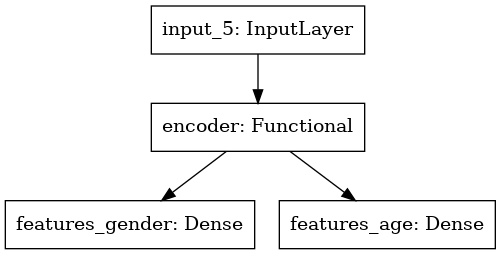

In [17]:
encoder = create_encoder()
loss = []
loss_weights = []
for col in target_col:
    loss.append(SupervisedContrastiveLoss(temperature))
    loss_weights.append(0.1)
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=loss,
    loss_weights=loss_weights
)

encoder_with_projection_head.summary()
keras.utils.plot_model(encoder_with_projection_head)

In [18]:
history = encoder_with_projection_head.fit(
    train_iter, batch_size=batch_size, epochs=num_epochs
)


Epoch 1/50
2328/2328 [==============================] - 379s 161ms/step - loss: 0.8097 - features_gender_loss: 3.9427 - features_age_loss: 4.1542
Epoch 2/50
2328/2328 [==============================] - 374s 161ms/step - loss: 0.7943 - features_gender_loss: 3.7933 - features_age_loss: 4.1493
Epoch 3/50
2328/2328 [==============================] - 375s 161ms/step - loss: 0.7886 - features_gender_loss: 3.7446 - features_age_loss: 4.1414
Epoch 4/50
2328/2328 [==============================] - 374s 160ms/step - loss: 0.7850 - features_gender_loss: 3.7192 - features_age_loss: 4.1312
Epoch 5/50
2328/2328 [==============================] - 374s 161ms/step - loss: 0.7823 - features_gender_loss: 3.7001 - features_age_loss: 4.1225
Epoch 6/50
2328/2328 [==============================] - 374s 160ms/step - loss: 0.7801 - features_gender_loss: 3.6862 - features_age_loss: 4.1150
Epoch 7/50
2328/2328 [==============================] - 375s 161ms/step - loss: 0.7784 - features_gender_loss: 3.6752 - feat

<Response [200]>

In [19]:
callbacks = []
if len(target_col) == 1:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)
else:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_{}_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)

In [20]:
classifier = create_classifier(encoder, trainable=False, training=False)
history = classifier.fit(train_iter, batch_size=batch_size, epochs=10, validation_data=val_iter, callbacks=callbacks)

Epoch 1/10
2328/2328 [==============================] - 279s 119ms/step - loss: 0.0763 - gender_loss: 0.0382 - age_loss: 0.7249 - gender_sparse_categorical_accuracy: 0.9920 - age_sparse_categorical_accuracy: 0.6949 - val_loss: 0.0812 - val_gender_loss: 0.0615 - val_age_loss: 0.7502 - val_gender_sparse_categorical_accuracy: 0.9833 - val_age_sparse_categorical_accuracy: 0.6661


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
2328/2328 [==============================] - 271s 116ms/step - loss: 0.0747 - gender_loss: 0.0346 - age_loss: 0.7122 - gender_sparse_categorical_accuracy: 0.9926 - age_sparse_categorical_accuracy: 0.6999 - val_loss: 0.0809 - val_gender_loss: 0.0630 - val_age_loss: 0.7463 - val_gender_sparse_categorical_accuracy: 0.9837 - val_age_sparse_categorical_accuracy: 0.6740
Epoch 3/10
2328/2328 [==============================] - 267s 114ms/step - loss: 0.0744 - gender_loss: 0.0343 - age_loss: 0.7100 - gender_sparse_categorical_accuracy: 0.9928 - age_sparse_categorical_accuracy: 0.7014 - val_loss: 0.0804 - val_gender_loss: 0.0668 - val_age_loss: 0.7370 - val_gender_sparse_categorical_accuracy: 0.9838 - val_age_sparse_categorical_accuracy: 0.6761
Epoch 4/10
2328/2328 [==============================] - 266s 114ms/step - loss: 0.0744 - gender_loss: 0.0340 - age_loss: 0.7100 - gender_sparse_categorical_accuracy: 0.9926 - age_sparse_categorical_accuracy: 0.7006 - val_loss: 0.0807 - val_gend

<Response [200]>

In [21]:
classifier.trainable = True
classifier.summary()
history = classifier.fit(train_iter, batch_size=batch_size, epochs=num_epochs, initial_epoch=10, validation_data=val_iter, callbacks=callbacks)
classifier.save('./ckpt/{}-{}.h5'.format(script_name, 'last'))

Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2048)         23564800    input[0][0]                      
__________________________________________________________________________________________________
dropout_gender (Dropout)        (None, 2048)         0           encoder[1][0]                    
__________________________________________________________________________________________________
dropout_age (Dropout)           (None, 2048)         0           encoder[1][0]                    
_________________________________________________________________________________________

In [22]:
res = []
names = []
for stage in stages:
    names.append(script_name_template.format(version, dataset, net, stage) + '-{}.h5')
for name in names:
    for col in target_col + ['last']:
        model_file = 'ckpt/' + name.format(col)
        model = keras.models.load_model(model_file)
        eval_res = model.evaluate(val_iter)
        eval_res = [name.format(col)] + eval_res
        res.append(eval_res)
columns = ['name', 'total_loss']
if len(target_col) == 1:
    columns.append('acc')
else:
    for m in ['loss', 'acc']:
        for col in target_col:
            columns.append('{}_{}'.format(col, m))
df_res = pd.DataFrame(res, columns = columns)
df_res.to_csv('Compare - Scratch - SupCon - {} - {}.csv'.format(version, dataset))

259/259 [==============================] - 28s 106ms/step - loss: 0.0805 - gender_loss: 0.0638 - age_loss: 0.7410 - gender_sparse_categorical_accuracy: 0.9842 - age_sparse_categorical_accuracy: 0.6770
